# <u> Data Cleaning </u>

The purpose of this notebook is to perform all necessary data cleaning, feature engineering, and dataset preparation steps based on the exploratory data analysis conducted in the previous notebook (`eda_fe.ipynb`). Given the size of the dataset, we will leverage SQL queries through the `duckdb` package to efficiently handle large-scale filtering and joins.

## <u> 0. Import libraries and dataframes:</u>

In [7]:
# Import libraries

import pandas as pd, numpy as np, os, sys, duckdb, matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.preprocessing import MultiLabelBinarizer

# Set repository directory
current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import modules
from modules.data_analysis import data_quality_summary

In [ ]:

# Import dataframe
rating_df = pd.read_csv('../data/raw/rating.csv', parse_dates=["timestamp"])
tag_df = pd.read_csv('../data/raw/tag.csv', parse_dates=["timestamp"])
movie_df = pd.read_csv('../data/raw/movie.csv')
link_df = pd.read_csv('../data/raw/link.csv')
genome_score_df = pd.read_csv('../data/raw/genome_scores.csv')
genome_tags_df = pd.read_csv('../data/raw/genome_tags.csv')


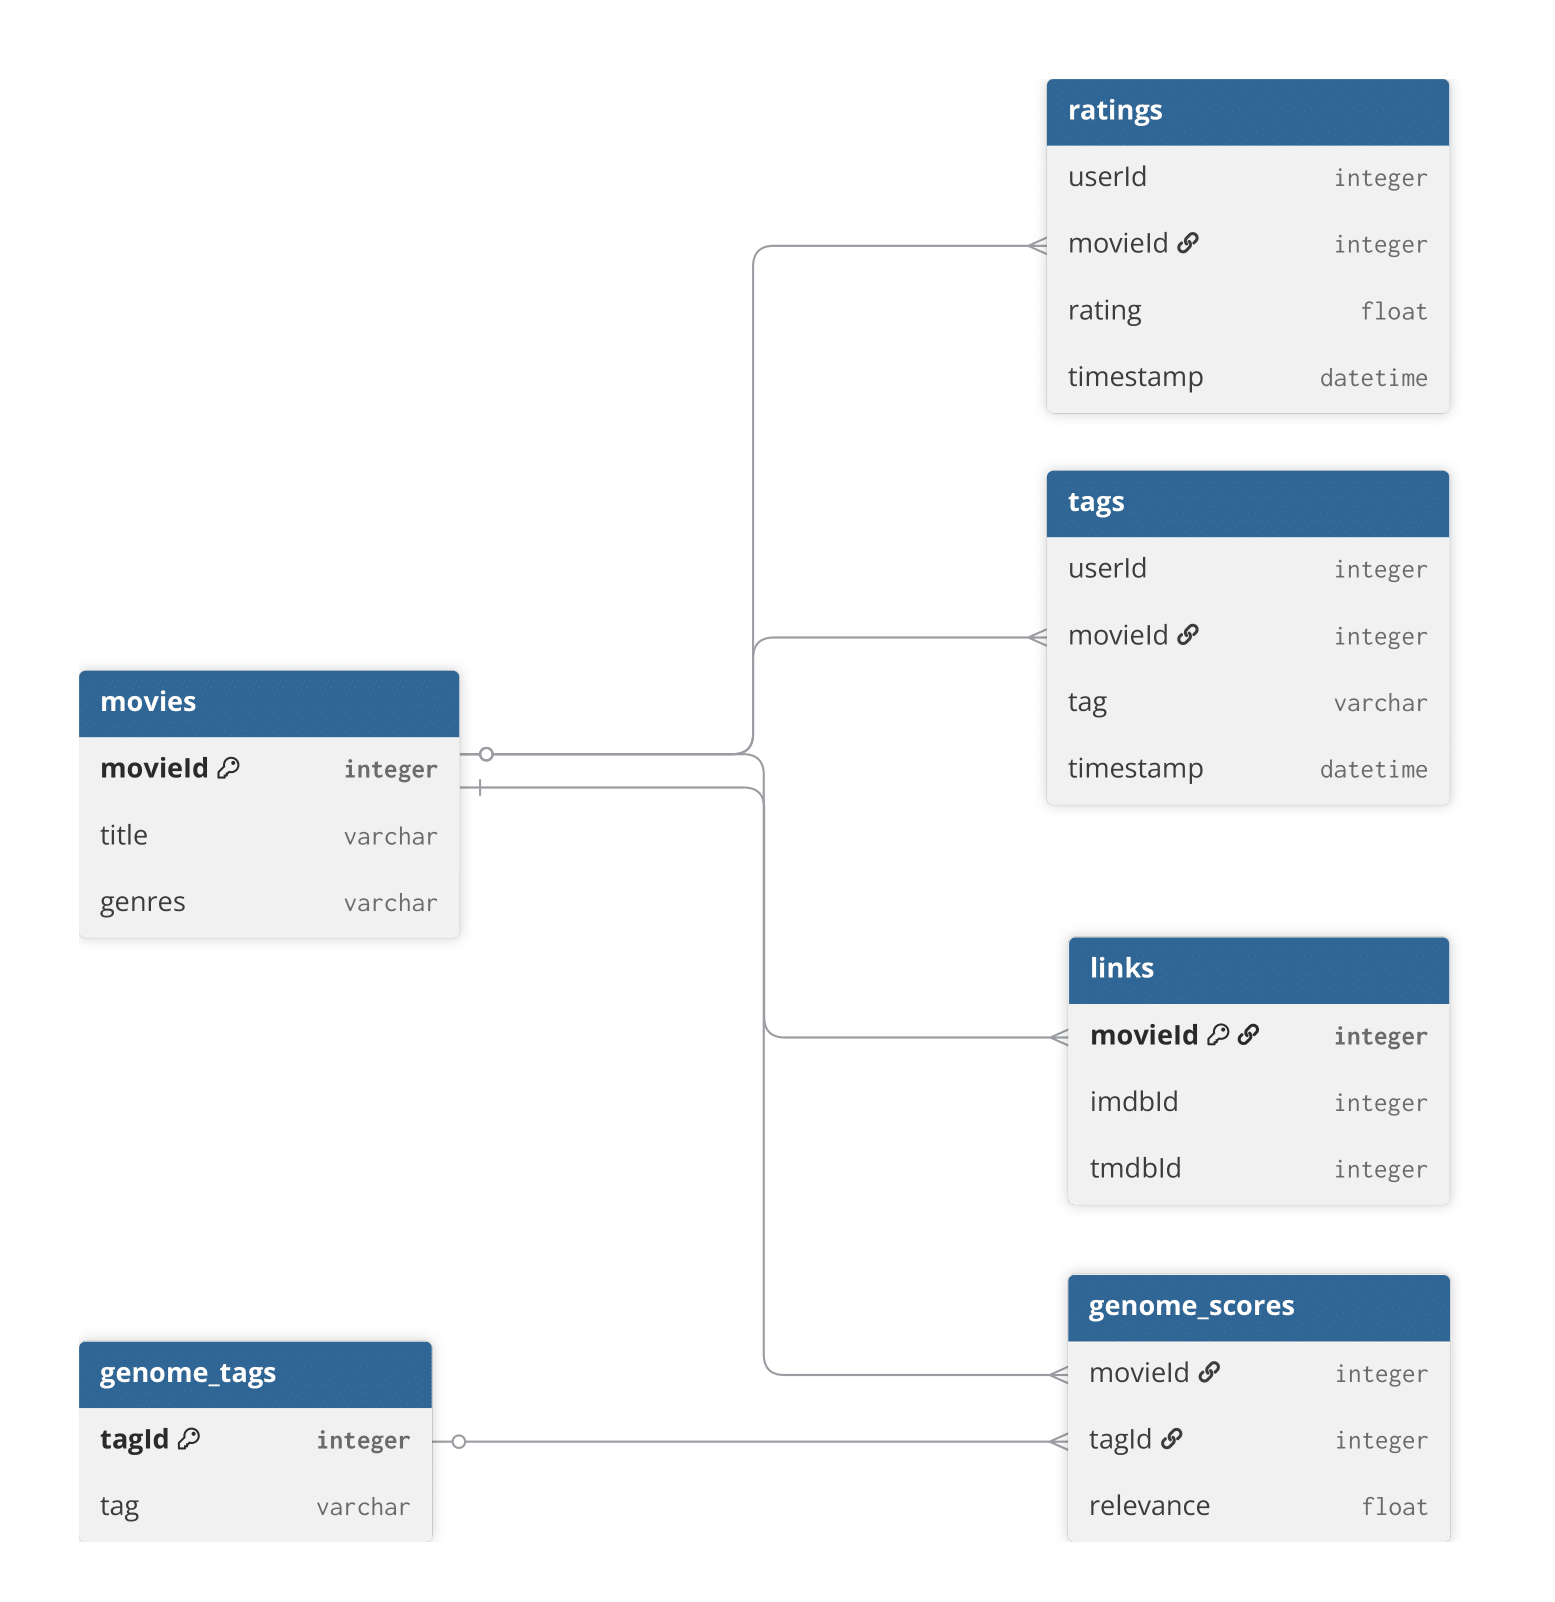

In [6]:
Image(filename='images/diagram_schema.png', width=500) 

## <u>1. User-Movie Enriched Ratings (`base_rec_dataset`)</u>

In this initial preprocessing stage, I focus only on the ratings and movies tables to build a base dataset enriched with useful features such as genres, rating counts, and Bayesian-adjusted scores. This dataset is intended for traditional recommendation models like collaborative filtering, matrix factorization, or content-based approaches, which rely on user-item interactions or basic item attributes. At this stage, adding auxiliary information such as tags or genome scores would unnecessarily increase the feature space, potentially leading to higher computational costs and the risk of overfitting due to the curse of dimensionality. Such additional data becomes more useful in advanced models that aim to capture semantic similarity or leverage graph-based user-item relationships to extract richer information.

To construct this first dataset, the following steps will be applied:

- Merge dataframes using primary and foreign keys  
- Filter out:
  - Entries with missing values
  - Movies with fewer than 20 ratings  
  - Genre with "no genres listed"

- Compute and include the Bayesian average rating as a covariate  
- Include the popularity of each movie (i.e., number of ratings) as a covariate  
- Extract and include the release year from movie titles as a covariate  
- One-hot encode genres into a multi-hot vector and merge into the main movie dataframe   
- Log-transform skewed variables such as popularity  
- User-average rating: controls for user's personal rating tendency (generous or strict rater)
- User-average Bayesian rating: captures the average quality of movies the user tends to watch (preference trend)

In [3]:
# Remove tags missing values
tag_df_cleaned = tag_df.dropna()


# Only include movies with at least 20 reviews
movie_rating_count = (
    rating_df[['movieId', 'rating']]
    .groupby('movieId')
    .count()
    .rename(columns={'rating': 'rating_count'})
    .reset_index()
)

movieId_keep = movie_rating_count[movie_rating_count['rating_count'] >= 20]['movieId']
rating_df_cleaned = rating_df[rating_df['movieId'].isin(movieId_keep)].copy()


# Compute Bayesian rating
rating_df_grouped = rating_df_cleaned.groupby('movieId').agg(
    rating_count=('rating', 'count'),
    average_rating=('rating', 'mean')
).reset_index()

rating_df_grouped = pd.merge(movie_df[['movieId', 'title']], rating_df_grouped, on='movieId', how='right')
m = 20
C = rating_df_grouped['average_rating'].mean()
rating_df_grouped['Bayes_rating'] = ( (rating_df_grouped['rating_count'] / (rating_df_grouped['rating_count']+m))* rating_df_grouped['average_rating'] + 
                                    (m/(rating_df_grouped['rating_count'] +m)) * C )

# Map information into rating_df
movieId_B_rating_map = rating_df_grouped.set_index('movieId')['Bayes_rating']
rating_df_cleaned['movie_bayes_avg'] = rating_df_cleaned['movieId'].map(movieId_B_rating_map)


# Drop movies without genre
movie_df['genre_list'] = movie_df['genres'].str.split('|')
movies_exploded = movie_df.explode('genre_list')
rating_genre_df = pd.merge(rating_df_cleaned,movies_exploded[['movieId', 'genre_list']], on = 'movieId', how='left')
no_genre_movie_ids = rating_genre_df[rating_genre_df['genre_list'] == '(no genres listed)']['movieId'].unique()
rating_df_cleaned = rating_df_cleaned[~rating_df_cleaned['movieId'].isin(no_genre_movie_ids)].copy()
movie_df_cleaned = movie_df[~movie_df['movieId'].isin(no_genre_movie_ids)].copy()


# Log count rating per movies
rating_count_map = rating_df_grouped.set_index('movieId')['rating_count']
rating_df_cleaned['log_count_review'] = np.log1p(rating_df_cleaned['movieId'].map(rating_count_map))


# Extract year of release of the movies
movie_df['release_year']= (pd.to_datetime(movie_df['title'].str.extract(r'\((\d{4})\)')[0],
                                           format='%Y', errors='coerce').dt.year.astype('Int64'))
rating_df_cleaned = rating_df_cleaned.merge(
    movie_df[['movieId', 'release_year']], on='movieId', how='left'
)


# Multi hot-encoding genres
movie_df_cleaned = movie_df_cleaned[~movie_df_cleaned['genre_list'].apply(lambda genres: '(no genres listed)' in genres)].copy()
mlb = MultiLabelBinarizer()
genre_multi_hot = mlb.fit_transform(movie_df_cleaned['genre_list'])
genre_df = pd.DataFrame(genre_multi_hot, columns=mlb.classes_)
movie_df_f = pd.concat([movie_df_cleaned.reset_index(drop=True), genre_df], axis=1)


# Include users' average rating
rating_df_cleaned['user_avg_rating'] = rating_df_cleaned['userId'].map(
    rating_df_cleaned.groupby('userId')['rating'].mean()
)

# Include users' average Bayes rating of movie watched
rating_df_cleaned['user_avg_bayes'] = rating_df_cleaned['userId'].map(
    rating_df_cleaned.groupby('userId')['movie_bayes_avg'].mean()
)

In [4]:
# Merge rating and movie information
movie_df_feature = movie_df_f.drop(columns=['genre_list'])
rating_final = rating_df_cleaned.merge(movie_df_feature, on = 'movieId', how='left')


In [3]:
# Define path file to store and retrive dataframe
save_dir = "../data/processed"
file_path = os.path.join(save_dir, "ratings_enriched.parquet")

In [4]:
# Used parquet instead of csv for efficiency purpose
# rating_final.to_parquet(file_path, index=False)

In [6]:
rating_enriched = pd.read_parquet(file_path, engine="pyarrow")
pd.set_option('display.max_columns', None)
rating_enriched.head(3)

,userId,movieId,rating,timestamp,movie_bayes_avg,log_count_review,release_year,user_avg_rating,user_avg_bayes,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,3.5,2005-04-02 23:53:47,3.211998,10.009828,1995,3.742857,3.630483,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,29,3.5,2005-04-02 23:31:16,3.950552,9.050289,1995,3.742857,3.630483,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0
2,1,32,3.5,2005-04-02 23:33:39,3.897760,10.713995,1995,3.742857,3.630483,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
